Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 115ms/step - loss: 0.0139
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - loss: 0.0036
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - loss: 0.0016
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - loss: 0.0013
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 155ms/step - loss: 0.0012
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - loss: 0.0010
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - loss: 0.0010
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - loss: 0.0010    
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - loss: 9.9010e-04
Epoch 10/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - loss: 9.2357e-04
Epoch 11/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 190ms/step - loss: 8.2222e-04
Epoch 12/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - loss: 9.4326e-04
Epoch 13/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - loss: 7.8971e-04
Epoch 14/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - loss: 0.0010
Epoch 15/100
14/14 ━━━━━━━━━━━━

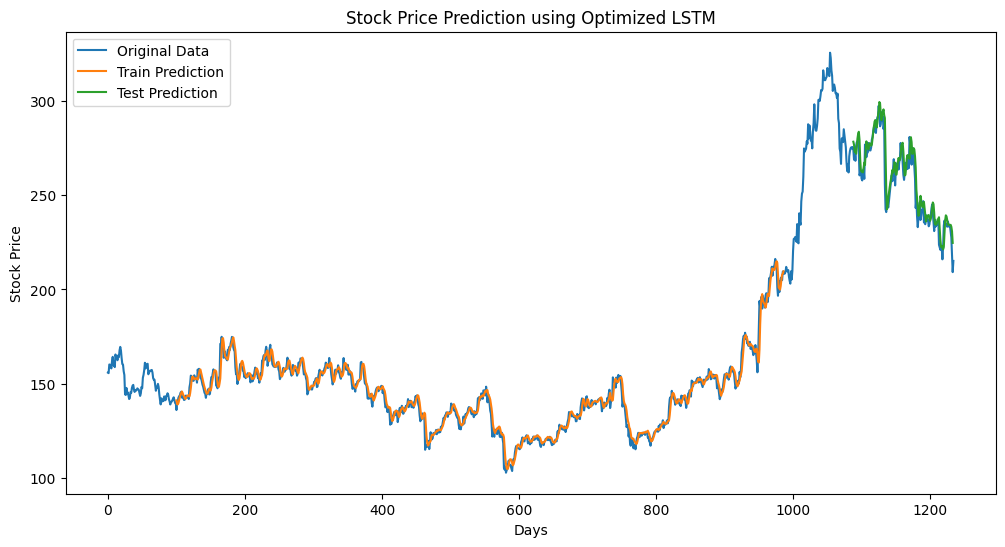

Training completed for 100 epochs.
RMSE: 7.396336240797121
R² Score: 0.8709


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import math

# Load and reverse data
df = pd.read_csv('NSE-Tata-Global-Beverages-Limited.csv')
df = df[::-1]
data = df.reset_index()['Close']

# Normalize data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(np.array(data).reshape(-1, 1))

# Split into train and test
train_size = int(len(data_scaled) * 0.8)
train, test = data_scaled[:train_size], data_scaled[train_size:]

# Create dataset
def create_dataset(dataset, step=100):
    X, y = [], []
    for i in range(len(dataset) - step - 1):
        X.append(dataset[i:i+step, 0])
        y.append(dataset[i+step, 0])
    return np.array(X), np.array(y)

time_step = 100
X_train, y_train = create_dataset(train, time_step)
X_test, y_test = create_dataset(test, time_step)

X_train = X_train.reshape(X_train.shape[0], time_step, 1)
X_test = X_test.reshape(X_test.shape[0], time_step, 1)

# Improved LSTM model
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(60, return_sequences=True, input_shape=(time_step, 1)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(60),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])
model.compile(loss='mean_squared_error', optimizer='adam')

# Train model
history = model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1)

# Predict and inverse scale
train_pred = scaler.inverse_transform(model.predict(X_train))
test_pred = scaler.inverse_transform(model.predict(X_test))
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
full_data = scaler.inverse_transform(data_scaled)

# Prepare plots
train_plot = np.empty_like(data_scaled)
train_plot[:, :] = np.nan
train_plot[time_step:len(train_pred)+time_step, :] = train_pred

test_plot = np.empty_like(data_scaled)
test_plot[:, :] = np.nan
test_plot[len(train_pred)+(time_step*2)+1:len(data_scaled)-1, :] = test_pred

# Plot
plt.figure(figsize=(12,6))
plt.plot(full_data, label='Original Data')
plt.plot(train_plot, label='Train Prediction')
plt.plot(test_plot, label='Test Prediction')
plt.legend()
plt.title('Stock Price Prediction using Optimized LSTM')
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.show()

# Metrics
rmse = math.sqrt(mean_squared_error(y_test_inv, test_pred))
r2 = r2_score(y_test_inv, test_pred)

print(f"Training completed for {len(history.history['loss'])} epochs.")
print(f"RMSE: {rmse}")
print(f"R² Score: {r2:.4f}")
